In [352]:
import numpy as np
import zarr
#import zipfile
import glob
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import uproot

In [353]:
file_list = glob.glob('<redacted>')
print("Number of files discovered",len(file_list))

Number of files discovered 8160


In [354]:
def get_meta(file_path):
    file = zarr.open(file_path,"r")
    lumi = file['LuminosityBlock'][0]# int(meta_data["luminosity_blocks"][0])
    run = file['RunNumber'][0] #int(meta_data["run_numbers"][0])
    orbits = file['OrbitNumber'] #meta_data["orbit_numbers"]
    return {"lumisection":lumi,"run":run,"orbits":orbits}
    
def populate_hash(files,hash_map):
    for file in files:
        try:
            meta = get_meta(file)
            hash_map[meta["run"]][meta["lumisection"]].append(file)
        except:
            pass
    return hash_map


hash_merge = defaultdict(lambda: defaultdict(list))
hash_merge = populate_hash(files = file_list,hash_map= hash_merge)

In [355]:
def get_data(file_path):
    f = zarr.open(file_path, 'r')
    return np.array(f['AxoScore'][:])

def get_scores_for_1_ls(lumi, run, hash_dict):
    files = hash_dict[run][lumi]
    scores = []
    for file in files:
        scores.append(get_data(file))
    scores = np.concatenate(scores,0)
    return scores

def get_thresFromrate(score, target_rate,bc_rate_hz = 11245.6 * 2544):
    return np.percentile(score, 100-(target_rate/bc_rate_hz)*100)

def get_rateFromthres(score,thres,bc_rate_hz = 11245.6 * 2544):
    return (np.where(score>thres)[0].shape[0]/score.shape[0])*bc_rate_hz

def filter_thresholds(lumi,thres):
    
    Q1 = np.quantile(thres, 0.25)
    Q3 = np.quantile(thres,0.75)
    IQR = Q3 - Q1
    
    LOWER_BOUND = Q1 - 1.5*IQR
    UPPER_BOUND = Q3 + 1.5*IQR
    
    accepted_indices = np.where((thres < UPPER_BOUND)*(thres > LOWER_BOUND))[0]
    for index in set(list(np.arange(0,thres.shape[0],1))) - set(accepted_indices):
        print(f"Rejected Threshold value for lumisection {lumi[index]} with threshold value of {thres[index]}")
    
    
    lumi = lumi[accepted_indices]
    thres = thres[accepted_indices]

    return lumi, thres

In [356]:
RUN = 392669
# RUN = 392997
lumisections = hash_merge[RUN].keys()

In [357]:
########################################################################################################
# Calculating the thresholds for different lumisections
###############
thres_for_lumi = {}
for l in tqdm(lumisections):
    thres_for_lumi[l] = get_thresFromrate(score = get_scores_for_1_ls(lumi=l,run=RUN,hash_dict=hash_merge),
                           target_rate=50)
########################################################################################################    

100%|██████████| 201/201 [03:03<00:00,  1.09it/s]


In [358]:
all_lumisections = np.array(list(thres_for_lumi.keys()))
all_thresholds = np.array(list(thres_for_lumi.values()))

In [359]:
all_lumisections,all_thresholds = filter_thresholds(lumi=all_lumisections,thres=all_thresholds)

Rejected Threshold value for lumisection 443 with threshold value of 2916.8622038960457
Rejected Threshold value for lumisection 422 with threshold value of 2649.561071038246
Rejected Threshold value for lumisection 506 with threshold value of 4999.1755598932505
Rejected Threshold value for lumisection 572 with threshold value of 2564.7571104839444


In [360]:
SET_THRESHOLD = np.median(all_thresholds)

In [361]:
SET_THRESHOLD = 2778

In [366]:
s_ = []
for l in tqdm(all_lumisections):
    s_.append(get_scores_for_1_ls(lumi=l,run=RUN,hash_dict=hash_merge))

100%|██████████| 197/197 [00:29<00:00,  6.69it/s]


In [370]:
score_all = np.concatenate(s_,0)

In [345]:
rates_for_lumi = {}
for i in tqdm(range(all_lumisections.shape[0])):
    rates_for_lumi[all_lumisections[i]] = get_rateFromthres(score = get_scores_for_1_ls(lumi=all_lumisections[i],
                                                                   run=RUN,
                                                                   hash_dict=hash_merge),
                           thres = all_thresholds[i])
    

100%|██████████| 197/197 [01:02<00:00,  3.16it/s]


In [346]:
observed_rate_cal = rates_for_lumi.values()
lumisection_cal = rates_for_lumi.keys()

Text(0.5, 1.0, 'Run 392669 CALCULATION RUN')

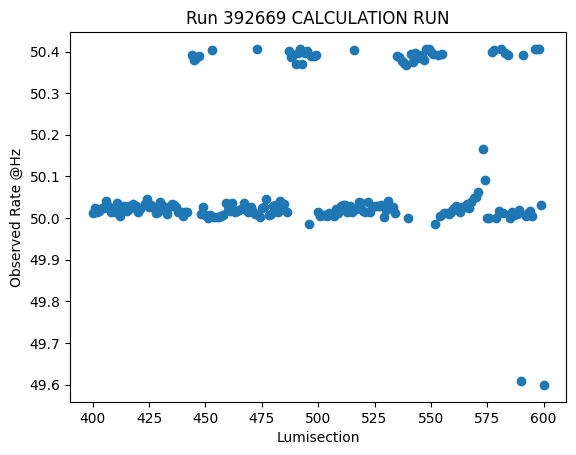

In [347]:
plt.scatter(lumisection_cal,observed_rate_cal)
plt.ylabel("Observed Rate @Hz")
plt.xlabel("Lumisection")
plt.title(f"Run {RUN} CALCULATION RUN")

In [348]:
RUN = 392997
# RUN = 392669
lumisections = hash_merge[RUN].keys()

In [349]:
########################################################################################################
# Calculating the thresholds for different lumisections
###############
rates_for_lumi = {}
for l in tqdm(lumisections):
    rates_for_lumi[l] = get_rateFromthres(score = get_scores_for_1_ls(lumi=l,run=RUN,hash_dict=hash_merge),
                           thres=SET_THRESHOLD)
########################################################################################################    

100%|██████████| 54/54 [00:17<00:00,  3.06it/s]


In [350]:
observed_rate_held = rates_for_lumi.values()
lumisection_held = rates_for_lumi.keys()

(30.0, 70.0)

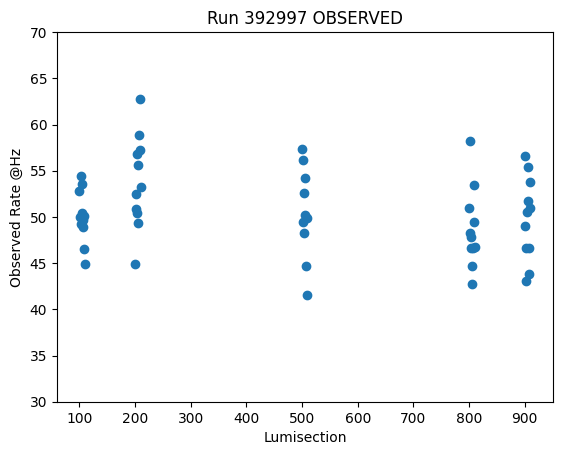

In [351]:
plt.scatter(lumisection_held,observed_rate_held)
plt.ylabel("Observed Rate @Hz")
plt.xlabel("Lumisection")
plt.title(f"Run {RUN} OBSERVED")
plt.ylim(30,70)